### Idea

且哥的一天有 48 小時，每個社群平台都可以滑滿 10 小時，留著 8 小時睡覺。不過她常看到推特上有些人會用尖酸苛薄的文字辱罵、霸凌他人；因此，且哥想要做一個網路霸凌偵測器，來辨識推文是否有霸凌，並分類該推文的主題（e.g., 宗教、年齡、種族、性別、其他、無霸凌）。

由於且哥不確定哪種提取文本特徵的方式較有效，也不確定要使用哪個模型作為分類器，因此他想請你利用已標記的推文資料集，**比較 [TfidfTransformer & Naive Bayes] 和 [Word2Vec & SVM] 兩個 [embedding&模型] 的組合**，告訴她哪一組的 wordembedding 和 classifier 能較好地預測推文是否與網絡霸凌相關。

1. 使用英文推文資料集，進行前處理（斷詞、去除停用詞、去除標點符號、去除數字、去除網址、去除 emoji、去除 @標註人）
2. 使用 TfidfTransformer >> Naive Bayes 進行推文分類預測
3. 使用 Word2Vec >> SVM 進行推文分類預測

## Setting

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/研/碩二/語料庫語言學/hw3-6')

In [ ]:
import pandas as pd
import numpy as np
import re
import joblib

In [ ]:
!pip install -U emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 14.4 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=0d53a202410f5052921e4df7762044eb9b82cf4fa58f117847208844a904f64b
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [ ]:
#Text cleaning
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
#stopwords = stopwords.words('english')

# Data preprocessing
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from collections import Counter
from gensim.models import Word2Vec

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')
matplotlib.rc('font', family = 'Taipei Sans TC Beta')

--2022-12-21 12:17:36--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.79.101, 173.194.79.138, 173.194.79.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.79.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b308fe8bd923mhlp9v11mc2a6k4tb882/1671625050000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=03ffd296-2020-42e3-9198-1e652efe55ff [following]
--2022-12-21 12:17:40--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b308fe8bd923mhlp9v11mc2a6k4tb882/1671625050000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=03ffd296-2020-42e3-9198-1e652efe55ff
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to doc-0k

## Data Import

In [ ]:
df = pd.read_csv('./cyberbullying_tweets.csv')

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'bully_type'})

In [ ]:
# bully types in raw data
df['bully_type'].value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: bully_type, dtype: int64

## Text Cleaning

In [ ]:
trash = "@[A-Za-z0-9]+|(?:\@|http?\://|https?\://|www)\S+|(\s\s+)|\'|\"|“|”" #  @ sign links spaces

def clean(text):
    text = re.sub(trash, '', str(text))
    text  = "".join([char for char in text if char not in string.punctuation])
    text = emoji.replace_emoji(text,'')           
    text = text.replace("#", "").replace("_", " ") #Remove # but keep the text
    text = text.lower()
     
    text = [word for word in text.split() if word not in stopwords]
    text = " ".join(text)
    return text

In [ ]:
df['text_clean'] = df['text'].apply(lambda x: clean(x))
df.head()

,text,bully_type,text_clean,text_len
0,"In other words #katandandre, your food was cra...",0,words katandandre food crapilicious mkr,9
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,aussietv white mkr theblock imacelebrityau tod...,14
2,@XochitlSuckkks a classy whore? Or more red ve...,0,classy whore red velvet cupcakes,8
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,gio meh pthanks heads concerned another angry ...,17
4,@RudhoeEnglish This is an ISIS account pretend...,0,isis account pretending kurdish accountlike is...,16


In [ ]:
df.drop_duplicates("text_clean", inplace=True)
df.shape

(43157, 4)

In [ ]:
df['bully_type'].value_counts()

4    7944
1    7879
2    7788
3    7473
0    6899
5    5174
Name: bully_type, dtype: int64

In [ ]:
TYPES = set(df['bully_type'])

In [ ]:
# add 'text_len'

text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

In [ ]:
df.sort_values(by=['text_len'], ascending=False)

,text,bully_type,text_clean,text_len
29205,is feminazi an actual word with a denot…\r\n@N...,5,feminazi actual word denot… job means protecti...,402
24516,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...,5,wutkindaat rate mkr final december mkr haha tr...,366
30752,I don't retreat.\r\nyessssssss http://t.co/Td9...,5,dont retreatyessssssss uh make grownups boruto...,244
44035,You so black and white trying to live like a n...,2,black white trying live like nigger pahahahaha...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",2,fuck obama dumb ass nigger bitch ltthis whore ...,165
...,...,...,...,...
3381,@KhaledHamaki Where did he say that?,0,say,1
25496,@ServbotMitch i'd be down for this.,5,id,1
3013,@truaemusic @mattybboi83 @Number10gov What are...,0,talking,1
11776,@RandomHero30 @rooshv @minasmith64 Who was she...,3,raped,1


In [ ]:
# remove text shorter than 5 words
df = df[df['text_len'] > 4]
len(df)

40788

In [ ]:
#joblib.dump(df,'./bully_tweet_df.pkl')

['./bully_tweet_df.pkl']

## Models

### Prepare data for NB

In [ ]:
# recode bully_type

df['bully_type'] = df['bully_type'].replace({'not_cyberbullying':0,
                                             'age':1,'ethnicity':2,'gender':3,'religion':4,
                                             'other_cyberbullying':5})

In [ ]:
X = df['text_clean']
y = df['bully_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4127],
       [   1, 5522],
       [   2, 5412],
       [   3, 5042],
       [   4, 5454],
       [   5, 2994]])

In [ ]:
# random over sample to balance the training data size of each bully_type
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'bully_type'])

X_train = train_os['text_clean'].values
y_train = train_os['bully_type'].values

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5522],
       [   1, 5522],
       [   2, 5522],
       [   3, 5522],
       [   4, 5522],
       [   5, 5522]])

In [ ]:
#@title -
#joblib.dump(X_train,'./bully_X_train.pkl')
#joblib.dump(y_train,'./bully_y_train.pkl')
#joblib.dump(X_test,'./bully_X_test.pkl')
#joblib.dump(y_test,'./bully_y_test.pkl')

['./bully_y_test.pkl']

### Naive Bayes baseline

In [ ]:
# bag of words
cv = CountVectorizer()
X_train_cv =  cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [ ]:
# associate weights to each word based on frequency 
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_model = MultinomialNB()

In [ ]:
nb_model.fit(X_train_tf, y_train)

nb_pred = nb_model.predict(X_test_tf)

In [ ]:
# results for NB prediction
print('Naive Bayes Accuracy {:.4f} \n'.format(accuracy_score(y_test,nb_pred)),
      classification_report(y_test, nb_pred, target_names=TYPES))


Naive Bayes Accuracy 0.8027 
                      precision    recall  f1-score   support

  not_cyberbullying       0.75      0.40      0.52      1812
                age       0.77      0.98      0.86      2238
          ethnicity       0.88      0.94      0.91      2250
           religion       0.85      0.84      0.84      2184
other_cyberbullying       0.86      0.96      0.91      2390
             gender       0.58      0.50      0.53      1363

           accuracy                           0.80     12237
          macro avg       0.78      0.77      0.76     12237
       weighted avg       0.79      0.80      0.79     12237



In [ ]:
def plot_confusion_matrix(y, y_pred, title, labels):

    fig, ax = plt.subplots(figsize=(9,9))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True,  cmap="Purples", fmt='g', cbar=False, annot_kws={"size":20}, )
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=10) 
    ax.yaxis.set_ticklabels(labels, fontsize=10)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

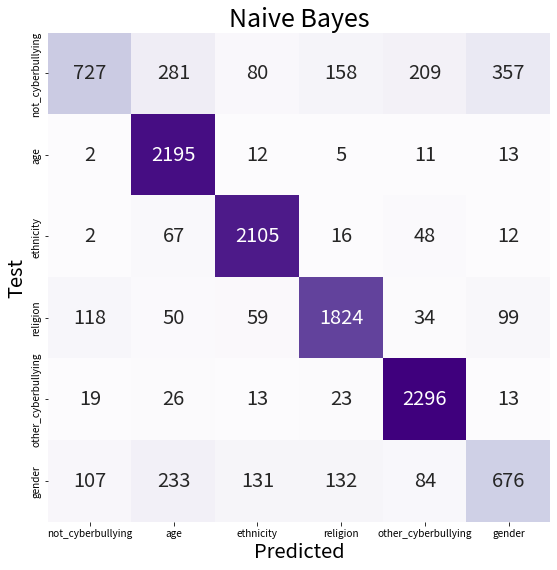

In [ ]:
plot_confusion_matrix(y_test, nb_pred, 'Naive Bayes', TYPES)

### Create Document Vectors from Word Embedding

In [ ]:
import joblib
df = joblib.load('./bully_tweet_df.pkl')

In [ ]:
df.head()

,text,bully_type,text_clean,text_len
0,"In other words #katandandre, your food was cra...",0,words katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,0,classy whore red velvet cupcakes,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,gio meh pthanks heads concerned another angry ...,9
4,@RudhoeEnglish This is an ISIS account pretend...,0,isis account pretending kurdish accountlike is...,7


**Build Word embeddings**

In [ ]:
def tokenize(texts):

  lists_of_list = []

  for text in texts:
    text = text.split()
    lists_of_list.append(text)

  return lists_of_list

In [ ]:
texts = tokenize(df['text_clean'])

In [ ]:
from gensim.models import Word2Vec

wv_model = Word2Vec(texts, size=128, workers=1, seed=101)

In [ ]:
wordindex = wv_model.wv.index2word
wordindex[:3]

['school', 'like', 'fuck']

In [ ]:
print(len(wv_model.wv.vocab))
print(wv_model.wv['school'])

9725
[ 0.30786952  0.6327348   0.41404128  0.6452687  -0.95099354 -2.2727928
  0.3558041  -1.0518303   1.0579127   1.1479325  -0.20076926  0.34286445
 -0.39589378 -0.01518199 -1.6437486   0.35623547  0.6957668  -0.1874421
 -0.999378    1.0672258  -0.9358268  -0.14952853  0.75211596 -0.10863407
  2.0636935   0.98162985  0.483974   -0.11103529  1.6193327   1.4999253
 -0.6449672  -0.4701105  -0.52683854 -0.07501917  0.06263718 -1.968032
  0.27055687 -0.02475701 -0.5819851  -0.48314488 -1.1232756  -0.51304877
  0.54230064 -0.06913551  1.3966599   1.2595912  -1.0612055  -0.47355786
  0.71554285  1.8519518   0.6567778   1.5011111  -1.520837   -0.08280531
  0.00648812 -0.7048205  -0.8165003  -0.9442642  -0.8050616   0.81918246
  0.1523893  -0.7613177  -0.17789395 -0.7809251   0.2632249  -1.8488497
  0.6090605  -0.3205671   0.30335566  0.33239445  1.2080976  -1.7059709
  0.24030861 -0.1759269  -0.7174437   0.4190199  -0.7834561   0.10470714
  1.6135457  -0.79882085  0.30870372  0.3529628   0.1

In [ ]:
wv_model.save("./bully_wv.model")
# model = Word2Vec.load("bully_wv.model")

In [ ]:
def vectorize(list_of_docs, model):

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [ ]:
vectorized_texts = vectorize(texts, model=wv_model)
len(vectorized_texts)

40788

In [ ]:
vectorized_texts[0]

array([ 0.16318648, -0.35792857,  0.5984179 ,  0.27134088,  0.07560138,
        0.44308907,  0.10584635, -0.01243   , -0.23824894,  0.050572  ,
        0.14191619,  0.03820517,  0.21156687, -0.18510976,  0.4174275 ,
        0.39110547, -0.0940025 ,  0.16446118,  0.07408677, -0.08833196,
       -0.04818847, -0.33843267, -0.01014962, -0.08849698,  0.41599277,
        0.22541958, -0.16333395,  0.25670096, -0.4987706 ,  0.42605975,
        0.13808717, -0.16455334, -0.09683028,  0.08808897,  0.42302555,
       -0.00999388,  0.21159127, -0.78938395, -0.22518906, -0.1048715 ,
       -0.40899265, -0.7028111 ,  0.3212836 ,  0.32542813, -0.26681808,
        0.02659268,  0.21964452,  0.03096921,  0.3725414 ,  0.4211905 ,
       -0.07225779, -0.08391269, -0.30314046,  0.3878992 ,  0.2229501 ,
        0.04568146, -0.14959076,  0.04078716,  0.49988586,  0.18502471,
        0.19041912,  0.02814177,  0.2468533 ,  0.10147275,  0.19585046,
        0.00969085, -0.23576453,  0.35132572, -0.12179836,  0.03

In [ ]:
#joblib.dump(vectorized_texts,'./bully_vectorized_texts.pkl')

['./bully_vectorized_texts.pkl']

### SVM

In [ ]:
import joblib
df = joblib.load('./bully_tweet_df.pkl')
vectorized_texts = joblib.load('./bully_vectorized_texts.pkl')
PCA_components = joblib.load('./bully_PCA_components.pkl')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_texts, df['bully_type'], test_size=0.3, random_state=101)

In [ ]:
from sklearn import svm

clf = svm.SVC(kernel='linear') 

In [ ]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
{'not_cyberbullying':0, 'age':1,
 'ethnicity':2, 'gender':3,
 'religion':4, 'other_cyberbullying':5}

In [ ]:
print('SVM Accuracy {:.4f} \n'.format(accuracy_score(y_test,y_pred)),
      classification_report(y_test, y_pred))

SVM Accuracy 0.7790 
               precision    recall  f1-score   support

           0       0.50      0.66      0.57      1812
           1       0.92      0.94      0.93      2238
           2       0.88      0.89      0.88      2250
           3       0.85      0.76      0.81      2184
           4       0.85      0.90      0.88      2390
           5       0.52      0.30      0.38      1363

    accuracy                           0.78     12237
   macro avg       0.75      0.74      0.74     12237
weighted avg       0.78      0.78      0.77     12237



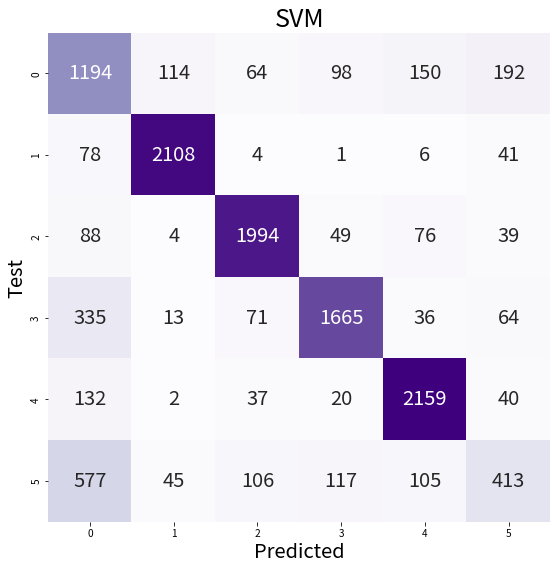

In [ ]:
plot_confusion_matrix(y_test, y_pred, 'SVM', set(y_test))